# Capstone: Italian Options in Houston, TX
## Background & Problem
In addition to actually trying to get work done, I expect random "taskers" from my leadership at company XYZ. The company will be sending sales representatives to a convention in the City of Houston, Texas in the Southwestern United States with a specific senior financial executive in mind. They know the executive loves Italian Food, but this is XYZ's first trip to Texas.

The Sales team of company XYZ wants to make sure they select an Italian Restaurant that is well reviewed and the legal department wants to be sure crime statistics impact that decision.

## The Data

### The City of Houston OpenData Website
This resource provides a GeoJSON for the individual areas of operation of the various departments of the Houston Police Departments. In this case divided up by "beats". This website is much needed as wikipedia entries for Houston are lacking in comparison to some other examples available. The use of these map boundaries is significant as publically available crime data for Houston is only categorized by beats.

### Houston Police Department Crime Data
This resource is only available as an xls file and ,again, only available by beat. The file comprosed over 60,000 crimes between 01 Jan 2020 and 04 25 2020 and is the only official release for crime data for Houston. The columns of the xls are 'Incident', 'Occurrence\nDate', 'Occurrence\nHour', 'NIBRS Class', 'NIBRSDescription', 'Offense\nCount', 'Beat', 'Premise', 'Block Range','StreetName', 'Street\nType', 'Suffix', 'City', 'ZIP Code. Due to the size of the data, I intend to use the Geopandas library to merge polygons of the beats GeoJSON with this file as a dataframe in order to assign geospatial value to the crime data.

### The Foursquare API
Unfortunately, my company is uncomfortable with the idea of use-limits and I will be limited to sandbox access to foursquare. In order to establish restaurants of interest, I will explore italian restaurants in areas deemed safest for that purpose.  This will reduce the number of calls needed and satisfy company requirements.

## Workflow
### Import the Data
    beats_url = "https://opendata.arcgis.com/datasets/fb3bb02ec56c4bb4b9d0cf3b8b3e5545_4.geojson"
    beats = gpd.read_file(beats_url)
    crimes = pd.read_excel("https://www.houstontx.gov/police/cs/xls/NIBRSPublicViewJan1-Apr30-2020-FINAL.xls")
### Initial Manipulations
Due to their being so many results, I will limit my search by date and I will focus on crimes pertaining to restaurants as that is what is most important to my near-term goals.

### Test Maps and Merge
I made a test map to ensure my police beats GeoJSON works properly. I format my crime data so as to make it easier to intepret and use a merge so the crime data has geographic polygons. I merge on right so we keep the GeoDataFrame as opposed to the Dataframe. The merge didn't return any errors, but head wouldn't tell us what the conversion did. "isinstance" checks if a variable is what we think it is.

### Geometry Types, Overlay, and New Centroids
A test map of the restaurant crime data shows multiple police beats with no restaurant related crime in 2020. Additional manipulation is required to identify these beats based on the map data.
1. Geopandas geometry types must be formatted as MultiPolygon.
2. Empty geometries must be dropped.
3. The Geopandas Overlay method is used to identify polygons with no restaurant crime data.

### Italian Food, Spatial Comparison, and Final Choice
I will develop a score based on averages of types of crime occuring at restaurants in Houston overall relative to a police beat. Neghborhoods scoring in the top 10 will be carried on to the next step. I will call the Foursquare API using the centroids of each police beat in Houston, calls are made to the Foursquare API to return the top 10 Italian venues in a radius of 500 meters.  Utilize one hot encoding to transform our list of established venues in the top 10, group by beat. I will use k-means and map cluster results.

In [162]:
import pandas as pd
import geopandas as gpd
import rtree
import folium
import json
import requests #
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely import wkt
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopandas.tools import geocode

%matplotlib inline

In [2]:
h_hood_url = "https://opendata.arcgis.com/datasets/deae15e7f3db4b198946c17f0d169c39_3.geojson"
beats_url = "https://opendata.arcgis.com/datasets/fb3bb02ec56c4bb4b9d0cf3b8b3e5545_4.geojson"
hoods = gpd.read_file(h_hood_url)
beats = gpd.read_file(beats_url)
zips = gpd.read_file(zips_url)
crimes = pd.read_excel("https://www.houstontx.gov/police/cs/xls/NIBRSPublicViewJan1-Apr30-2020-FINAL.xls")

In [33]:
crimes_shape = crimes.shape
beats_shape = beats.shape
print("Shape of crimes Dataframe = {}\nShape of beats GeoDataframe = {}".format(crimes_shape, beats_shape))

Shape of crimes Dataframe = (65499, 7)
Shape of beats GeoDataframe = (118, 10)


<p> We can see below that there are no coordinates in the crimes DataFrame, but it is populated by column beats. Due to the rate limits of Foursquare we need to prepare the DataFrame by familiarizing with it, removing uneseccary columns, and narrowing the categories we will use for analysis as this is too much to geocode without additional cost.</p>

In [27]:
crimes.head(2)

,Incident,Occurrence Date,Occurrence Hour,NIBRS Class,NIBRSDescription,Offense Count,Beat,Premise,Block Range,StreetName,Street Type,Suffix,City,ZIP Code
0,8220,2020-01-01,0,23G,Theft of motor vehicle parts or accessory,1,8C50,"Residence, Home (Includes Apartment)",9311,BELLA PINE,CT,NaN,HOUSTON,77078
1,18920,2020-01-01,0,13A,Aggravated Assault,1,17E30,"Residence, Home (Includes Apartment)",8701,GUSTINE,LN,NaN,HOUSTON,77031


In [28]:
crimes['Address'] = crimes['Block Range'].map(str) + " " + crimes['StreetName'].map(str) + " " + crimes['City'].map(str) + ", TX, " + crimes['ZIP Code'].map(str)

In [29]:
crimes.columns

Index(['Incident', 'Occurrence\nDate', 'Occurrence\nHour', 'NIBRS\nClass',
       'NIBRSDescription', 'Offense\nCount', 'Beat', 'Premise', 'Block Range',
       'StreetName', 'Street\nType', 'Suffix', 'City', 'ZIP Code', 'Address'],
      dtype='object')

In [30]:
crimes = crimes.drop(['Occurrence\nHour', 'NIBRS\nClass','Block Range', 'StreetName', 'Street\nType', 'City', 'Suffix', 'ZIP Code'], axis=1)

In [35]:
crimes = crimes.rename(columns={'Occurrence\nDate': 'Date', 'NIBRSDescription': 'Offense'})
crimes.head(2)
crimes = crimes.dropna()

In [12]:
crimes['Offense'].value_counts()

Theft from motor vehicle                     1174
Simple assault                                850
Destruction, damage, vandalism                784
Shoplifting                                   773
All other larceny                             597
Burglary, Breaking and Entering               580
Intimidation                                  556
Aggravated Assault                            518
Motor vehicle theft                           456
Robbery                                       396
Drug, narcotic violations                     296
Theft of motor vehicle parts or accessory     278
Theft from building                           196
Weapon law violations                         118
Credit card, ATM fraud                        104
Identify theft                                 81
Counterfeiting, forgery                        76
False pretenses, swindle                       75
Drug equipment violations                      41
Embezzlement                                   24


In [32]:
crimes['Premise'].value_counts()

Residence, Home (Includes Apartment)    25147
Parking Lot, Garage                     13127
Highway, Road, Street, Alley             7890
Other, Unknown                           2257
Department, Discount Store               2182
Commercial, Office Building              1780
Convenience Store                        1771
Restaurant                               1711
Service, Gas Station                     1546
Hotel, Motel, ETC                        1181
Speciality Store                         1092
Grocery, Supermarket                      992
Drug Store, Doctors Office, Hospital      706
Bar, Nightclub                            554
Airplane, Bus,Train Terminal              467
Park/Playground                           443
Shopping Mall                             338
Construction Site                         318
Rental Storage Facility                   305
Bank, Savings & Loan                      293
Auto Dealership New/Used                  252
Government, Public Building       

<p> We can use the focus of restaurants as that is what we are most interested in. Furthermore we will limit our datetime range to make the data more manageable. </p>
<p>To do this we will use the pandas loc method on the date and premise columns of the crimes dataframe,</p>

In [38]:
crimes['Date'] = pd.to_datetime(crimes['Date'])
start_date = '03-01-2020'
end_date = '04-25-2020'
mask = (crimes['Date'] > start_date) & (crimes['Date']  <= end_date)
crimes = crimes.loc[mask]
crimes = crimes.loc[crimes['Premise'] == "Restaurant"]
crimes.reset_index(drop=True)
crimes.head(2)

,Incident,Date,Offense,Offense Count,Beat,Premise,Address
36598,30997320,2020-03-02,Intimidation,2,19G50,Restaurant,"10712 BELLFORT HOUSTON, TX, 77099"
36624,29375620,2020-03-02,"Burglary, Breaking and Entering",1,18F60,Restaurant,"9110 SOUTHWEST HOUSTON, TX, 77036"


<p>I first tried to use Nominatim due to the limits of our foursquare access, but the operation never returned with and error message or success, likely due to the number of objects that needed to be passed for geocoding. I will now attempt to use the Houston Police Beats GeoJSON to produce a map and some centroids.</p>

Assigning centroids will enable Foursquare searches later and allow us to test our GeoJSON data to ensure it is usable.

,Beat,Beats_0,OBJECTID_1,OBJECTID,District,Area_sq_mi,Perimet_mi,OBJECTID_12,Shape_Leng,geometry
0,23J40,23J40,1,104,23,3.039335,9.254984,1,48866.313742,POINT (-95.16281975482278 29.607359151735)
1,23J50,23J50,2,105,23,2.123895,7.153639,2,37771.213441,POINT (-95.2775349557527 29.6459562855618)
2,1A10,01A10,3,1,1,1.746467,6.236709,3,32929.823999,POINT (-95.36244468671509 29.75778693911734)
3,1A20,01A20,4,2,1,2.441331,7.953352,4,41993.697388,POINT (-95.3890999797281 29.75182961104942)
4,1A30,01A30,5,3,1,2.659169,8.026355,5,42379.151925,POINT (-95.40870779116224 29.73978165807872)


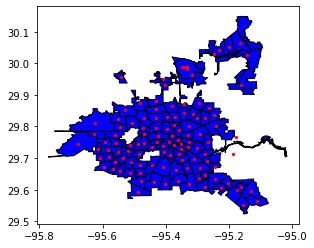

In [300]:
# Create and test to make sure the data works
beats_p = beats.copy()
beats_p['geometry'] = beats_p['geometry'].centroid
base = beats.plot(color='blue', edgecolor='black')
beats_p.plot(ax=base, marker='o', color='red', markersize=5);
beats_p.head()

In [90]:
# Use the polygons of Geodataframe beats to assign geographic values to our reastaurant crime DataFrame, crimes.
# Establish common attribute
beats = beats.rename(columns={'Beats': 'Beat'})
# Merge on right with the GeoDataFrame on the left side of the argument so we keep the GeoDataFrame as opposed to the Dataframe.
cri_geo = beats.merge(crimes, how="right", on='Beat')
# The merge didn't return any errors, but head wouldn't tell us what the conversion did. "isinstance" checks if a variable is what we think it is.
isinstance(cri_geo, gpd.GeoDataFrame)

True

,Beat,Beats_0,OBJECTID_1,OBJECTID,District,Area_sq_mi,Perimet_mi,OBJECTID_12,Shape_Leng,geometry,Incident,Date,Offense,Offense Count,Premise,Address
0,1A10,01A10,3.0,1.0,1.0,1.746467,6.236709,3.0,32929.823999,(POLYGON ((-95.35056999661641 29.7669801950511...,35298920,2020-03-13,Theft from motor vehicle,1,Restaurant,"1307 AUSTIN HOUSTON, TX, 77002"
1,1A10,01A10,3.0,1.0,1.0,1.746467,6.236709,3.0,32929.823999,(POLYGON ((-95.35056999661641 29.7669801950511...,39017920,2020-03-22,"Burglary, Breaking and Entering",1,Restaurant,"200 MILAM HOUSTON, TX, 77002"


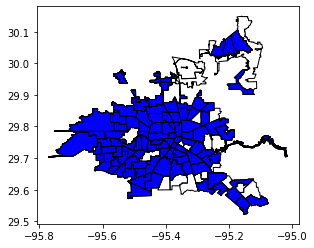

In [92]:
# Familiarize with cri_geo GeoDataFrame as a map
base2 = beats.plot(color='none', edgecolor='black')
cri_geo.plot(ax=base2, color='blue', edgecolor='black');
cri_geo.head(2)

We can see there are police beats with no restaurant related crimes. We should identify these so we can filter our foursquare data later.

In [143]:
# testing Geopandas methods explode and overlay to compare my GeoDataFrames
# Overlay only works with MultiPolygons so I need to convert the geometry columns of the GeoDataFrames to support that
cri_geo['geometry'] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in cri_geo["geometry"]]

beats['geometry'] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in beats["geometry"]]

# identify empty geometries 
test = cri_geo.loc[cri_geo['geometry'].isna() == True]
test

,Beat,Beats_0,OBJECTID_1,OBJECTID,District,Area_sq_mi,Perimet_mi,OBJECTID_12,Shape_Leng,geometry,Incident,Date,Offense,Offense Count,Premise,Address
575,OOJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31522420,2020-03-06,Simple assault,1,Restaurant,"12350 WESTHEIMER HOUSTON, TX, 77077"
576,OOJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33311220,2020-03-10,"Credit card, ATM fraud",1,Restaurant,"3930 FUQUA HOUSTON, TX, 77045"
577,OOJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33311220,2020-03-10,Theft from motor vehicle,1,Restaurant,"3930 FUQUA HOUSTON, TX, 77045"
578,OOJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48339620,2020-04-12,"Burglary, Breaking and Entering",1,Restaurant,"2002 LEXINGTON DEERPARK, TX, 77536"
579,HCSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32647720,2020-03-09,Robbery,1,Restaurant,"14220 CULLEN HARRIS CO, TX, 77047"
580,HCSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36181420,2020-03-16,Robbery,1,Restaurant,"2017 MAIN HARRIS CO, TX, 77562"
581,HCSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54230520,2020-04-25,"Burglary, Breaking and Entering",1,Restaurant,"8797 GESSNER HARRIS CO, TX, 77040"


In [144]:
# remove empty geometry rows
cri_geo = cri_geo.drop(index=cri_geo.index[[575, 576, 577, 578, 579, 580, 581]])

In [149]:
# Use overlay method to identify police beats with no restaurant related crimes
safer = gpd.overlay(beats, cri_geo, how='difference')

In [175]:
address = 'Houston, TX'

geolocator = Nominatim(user_agent="hou_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Houston are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Houston are 29.7589382, -95.3676974.


In [185]:
CLIENT_ID = '2CR5A2EY3KHURAHDXYHP2ZJPGAN1TSUDFDHL0A3HWNCEKJS5' # your Foursquare ID
CLIENT_SECRET = 'JBTL1ZGDQIGNBN1MQZQ3ZTWIZELYYLIRVUF1BKF0GTMONCKB' # your Foursquare Secret
VERSION = '20180604'
radius = 100000
search_query = 'Italian'
LIMIT = 100
VENUE_CAT = '4d4b7105d754a06374d81259'
# VENUE_CAT is the Foursquare catagory for food. I'm using this to work within the lower end rate limit
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2CR5A2EY3KHURAHDXYHP2ZJPGAN1TSUDFDHL0A3HWNCEKJS5
CLIENT_SECRET:JBTL1ZGDQIGNBN1MQZQ3ZTWIZELYYLIRVUF1BKF0GTMONCKB


In [193]:
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&query={}&limit={}&categoryId={}'.format(
    CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, search_query, LIMIT, VENUE_CAT)

In [231]:
results = requests.get(url2).json()
results

{'meta': {'code': 200, 'requestId': '5ec52a6f83525f001bbe8efe'},
 'response': {'venues': [{'id': '4b2a847cf964a520aaaa24e3',
    'name': 'Little Napoli Italian Cuisine',
    'location': {'address': '540 Texas St.',
     'lat': 29.7621244,
     'lng': -95.3668441,
     'labeledLatLngs': [{'label': 'display',
       'lat': 29.7621244,
       'lng': -95.3668441},
      {'label': 'entrance', 'lat': 29.762199, 'lng': -95.366674}],
     'distance': 364,
     'postalCode': '77007',
     'cc': 'US',
     'city': 'Houston',
     'state': 'TX',
     'country': 'United States',
     'formattedAddress': ['540 Texas St.',
      'Houston, TX 77007',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1589979834',
  

In [232]:
venues = results['response']['venues']
df = json_normalize(venues)
df.head(2)

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b2a847cf964a520aaaa24e3,540 Texas St.,...,364,"[540 Texas St., Houston, TX 77007, United States]","[{'label': 'display', 'lat': 29.7621244, 'lng'...",29.762124,-95.366844,77007,TX,Little Napoli Italian Cuisine,v-1589979834,NaN
1,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",NaN,NaN,NaN,NaN,NaN,NaN,False,5d5786cc44209c000842c714,800 Capitol St #T308,...,397,"[800 Capitol St #T308, Houston, TX 77002, Unit...","[{'label': 'display', 'lat': 29.76039114931157...",29.760391,-95.363935,77002,TX,Mona Fresh Italian,v-1589979834,NaN


In [233]:
#creating a GeoDataFrame for the Italian Food Data
geometry = [Point(xy) for xy in zip(df['location.lng'], df['location.lat'])]
crs = {'init': 'epsg:4326'}
it_geo = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [302]:
it_geo

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id,geometry
0,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b2a847cf964a520aaaa24e3,540 Texas St.,...,"[540 Texas St., Houston, TX 77007, United States]","[{'label': 'display', 'lat': 29.7621244, 'lng'...",29.762124,-95.366844,77007,TX,Little Napoli Italian Cuisine,v-1589979834,NaN,POINT (-95.36684409999999 29.7621244)
1,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",NaN,NaN,NaN,NaN,NaN,NaN,False,5d5786cc44209c000842c714,800 Capitol St #T308,...,"[800 Capitol St #T308, Houston, TX 77002, Unit...","[{'label': 'display', 'lat': 29.76039114931157...",29.760391,-95.363935,77002,TX,Mona Fresh Italian,v-1589979834,NaN,POINT (-95.36393523216248 29.76039114931157)
2,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",1739674,/delivery_provider_grubhub_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",grubhub,https://www.grubhub.com/restaurant/ritas-itali...,False,5ace947e8496ca64ba220763,2802 White Oak Dr,...,"[2802 White Oak Dr, Houston, TX 77007, United ...","[{'label': 'display', 'lat': 29.78192, 'lng': ...",29.781920,-95.388972,77007,TX,Rita's Italian Ice & Frozen Custard,v-1589979834,NaN,POINT (-95.388972 29.78192)
3,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,41326e00f964a52084121fe3,540 Texas St,...,"[540 Texas St (btw Bagby St and Smith St), Hou...","[{'label': 'display', 'lat': 29.762381, 'lng':...",29.762381,-95.366655,77002,TX,Mingalone Italian Bar & Grill,v-1589979834,NaN,POINT (-95.36665499999999 29.762381)
4,"[{'id': '4bf58dd8d48988d1f5941735', 'name': 'G...",NaN,NaN,NaN,NaN,NaN,NaN,False,5a611cc186bc491ad55e4f12,3605 White Oak Dr,...,"[3605 White Oak Dr (Harvard St), Houston, TX 7...","[{'label': 'display', 'lat': 29.781288, 'lng':...",29.781288,-95.396472,77007,TX,Italian American Grocery Co.,v-1589979834,NaN,POINT (-95.396472 29.781288)
5,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4e4c6ac1bd413c4cc6693781,1209 Caroline St,...,"[1209 Caroline St, Houston, TX 77002, United S...","[{'label': 'display', 'lat': 29.75356500000000...",29.753565,-95.363438,77002,TX,Josephine's Italian Ristorante,v-1589979834,NaN,POINT (-95.363438 29.753565)
6,"[{'id': '4d4b7105d754a06374d81259', 'name': 'F...",NaN,NaN,NaN,NaN,NaN,NaN,False,4f32913f19836c91c7e46a84,2905 Travis St,...,"[2905 Travis St, Houston, TX 77006, United Sta...","[{'label': 'display', 'lat': 29.743462, 'lng':...",29.743462,-95.376393,77006,TX,Italian Ice Hut,v-1589979834,NaN,POINT (-95.37639300000001 29.743462)
7,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b176297f964a52022c523e3,1608 Shepherd Dr,...,"[1608 Shepherd Dr (Eigel St.), Houston, TX 770...","[{'label': 'display', 'lat': 29.77505944139878...",29.775059,-95.409347,77007,TX,Spaghetti Western Italian Cafe,v-1589979834,37976685,POINT (-95.40934660217916 29.77505944139878)
8,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",NaN,NaN,NaN,NaN,NaN,NaN,False,4ba52de6f964a52058e838e3,1525 Westheimer Rd,...,"[1525 Westheimer Rd, Houston, TX 77006, United...","[{'label': 'display', 'lat': 29.74262472958950...",29.742625,-95.398729,77006,TX,Bambolino's Italian Cafe,v-1589979834,NaN,POINT (-95.39872880528127 29.7426247295895)
9,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",NaN,NaN,NaN,NaN,NaN,NaN,False,4a7b23e1f964a5201dea1fe3,1777 Airline Dr,...,"[1777 Airline Dr (W. Calvacade), Houston, TX 7...","[{'label': 'display', 'lat': 29.80284922268784...",29.802849,-95.382086,77009,TX,Chicago Italian Beef,v-1589979834,NaN,POINT (-95.38208594377636 29.80284922268784)


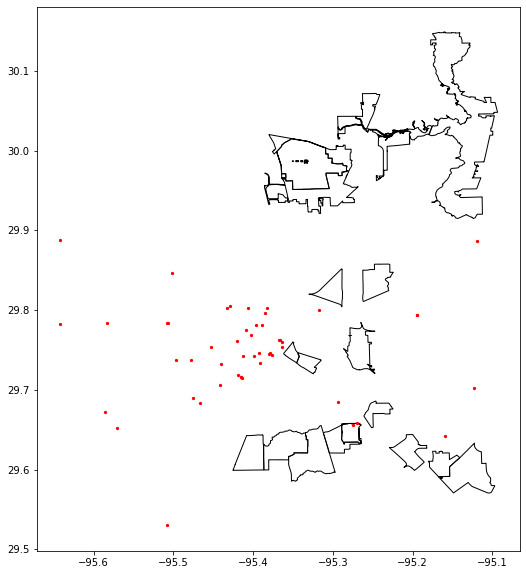

In [288]:
#It looks like  only a few restaurants are in the safe area
base2 = safer.plot(color='none', figsize=(15, 10), edgecolor='black')
it_geo.plot(ax=base2, marker='o', color='red', markersize=5);

In [297]:
# Find restaurants within the safe area and determine what police beat they are in
test_safe = safer.geometry.unary_union
test_it = it_geo[it_geo.geometry.within(test_safe)]
final_beat = gpd.sjoin(test_it, safer, how="inner", op='within')

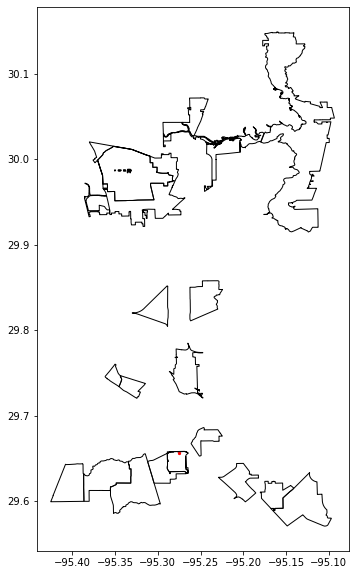

In [290]:
# Plot the results
base2 = safer.plot(color='none', figsize=(15, 10), edgecolor='black')
test_it.plot(ax=base2, marker='o', color='red', markersize=5);

In [298]:
test_it

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id,geometry
45,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4dcc748b1838a9a8d8013aca,NaN,...,"[Houston, TX 77061, United States]","[{'label': 'display', 'lat': 29.65629226895848...",29.656292,-95.274987,77061,TX,Carrabbas Italian Grill,v-1589979834,NaN,POINT (-95.27498679253274 29.65629226895849)


In [299]:
final_beat

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,index_right,Beat,Beats_0,OBJECTID_1,OBJECTID,District,Area_sq_mi,Perimet_mi,OBJECTID_12,Shape_Leng
45,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",NaN,NaN,NaN,NaN,NaN,NaN,False,4dcc748b1838a9a8d8013aca,NaN,...,1,23J50,23J50,2,105,23,2.123895,7.153639,2,37771.213441
